# Simple disagregate points

For each block, put a rectangle around the block.  Then intersect them.

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import os, lzma, csv, bz2, io, collections, pickle, re
import pyproj
import tilemapbase
import shapely.geometry

import open_cp.sources.chicago

In [2]:
#data_dir = os.path.join("/media", "disk", "Data")
data_dir = os.path.join("..", "..", "..", "..", "Data")
#os.listdir(data_dir)
filename = os.path.join(data_dir, "chicago_all_cleaned.csv.xz")

In [3]:
with lzma.open(filename, "rt", encoding="utf8") as f:
    reader = csv.reader(f)
    header = next(reader)
    out = collections.defaultdict(list)
    for row in reader:
        block, x, y = row[3], float(row[15]), float(row[16])
        x /= open_cp.sources.chicago._FEET_IN_METERS
        y /= open_cp.sources.chicago._FEET_IN_METERS
        out[block].append((x,y))
out = {k : np.asarray(out[k]) for k in out}
len(out)

51465

In [4]:
proj = pyproj.Proj({"init":"epsg:3528"})

# Merge repeats

Some simple rules...

In [41]:
p = re.compile("\dST")
st = "AGS 51ST agsa"
st ="bob"
x = p.search(st)
st[:x.start()+1] + st[x.end():]

AttributeError: 'NoneType' object has no attribute 'start'

In [51]:
postfix = {"AV":"AVE", "BL":"BLVD", "BV":"BLVD", "TR":"TER", "PW":"PKWY", "PL":"PLACE"}
digit_removals = {re.compile(x) for x in {"\dST", "\dTH", "\dRD", "\dND"}}
replaces = {"MC VICKER":"MCVICKER"}

def normalise(block):
    block = block.upper()
    for p in postfix:
        if block.endswith(" "+p):
            block = block[:-len(p)] + postfix[p]
    for p in digit_removals:
        m = p.search(block)
        if m:
            block = block[:m.start()+1] + block[m.end():]
    for p in replaces:
        block = block.replace(p, replaces[p])
    return block
        
assert normalise("04XX FISH st") == "04XX FISH ST"
assert normalise("AGSH AV") == "AGSH AVE"
assert normalise("AGSH 51ST AV") == "AGSH 51 AVE"
assert normalise("aGAS MC Vicker") == "AGAS MCVICKER"

In [52]:
cleaned = collections.defaultdict(list)
for k in out:
    key = normalise(k)
    cleaned[key].extend(out[k])
cleaned = {k:np.array(l) for k,l in cleaned.items()}
    
assert sum(len(l) for l in cleaned.values()) == sum(len(l) for l in out.values())
len(out), len(cleaned)

(51465, 34518)

In [53]:
centres = {k : np.mean(cleaned[k], axis=0) for k in cleaned}

In [54]:
keys = list(centres)
pts = np.asarray([centres[k] for k in keys])
for i, pt in enumerate(pts):
    dists = np.sqrt(np.sum((pts[i+1:,:] - pt)**2, axis=1))
    m = dists < 1
    for j, d in zip(np.arange(i+1, len(pts))[m], dists[m]):
        print(keys[i], keys[j], d)

070XX S ASHLAND AVE 070XX N ASHLAND AVE 0.128314493995
006XX S SACRAMENTO BLVD 006XX S SACRAMENTO AVE 0.548801041348
073XX S COLES AVE 073XX N COLES AVE 0.683089099971
025XX S KEDZIE AVE 025XX N KEDZIE AVE 0.360170346869
056XX S LOOMIS BLVD 056XX S LOOMIS ST 0.664280590461
009XX S OAKLEY BLVD 009XX S OAKLEY AVE 0.415902661859
0000X S KOSTNER AVE 000XX S KOSTNER AVE 0.81184359803
087XX S COTTAGE GROVE AVE 087XX S COTTAGE GROVE 0.0967631355836
016XX N CALIFORNIA AVE 016XX S CALIFORNIA AVE 0.159803581176
087XX S YATES BLVD 087XX S YATES AVE 0.798964114509


KeyboardInterrupt: 

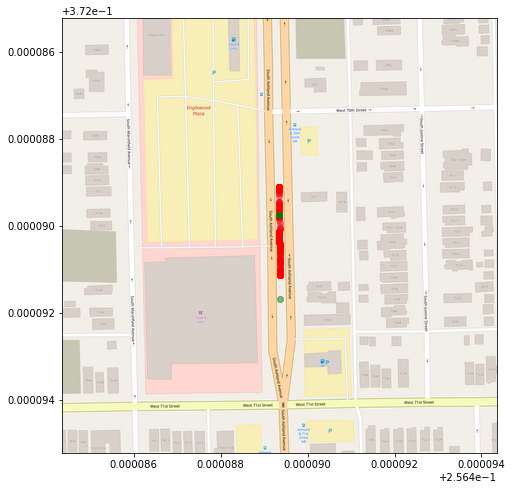

In [80]:
kk = "070XX S ASHLAND AVE", "070XX N ASHLAND AVE"

pts = [np.asarray([tilemapbase.project(*proj(x, y, inverse=True)) 
    for x,y in cleaned[k]]) for k in kk]    

fig, ax = plt.subplots(figsize=(8,8))
x, y = np.mean(pts[0][:,0]), np.mean(pts[0][:,1])
ex = tilemapbase.Extent.from_centre(x, y, xsize=0.00001)
plotter = tilemapbase.Plotter(ex, tilemapbase.tiles.OSM, width=800)
plotter.plot(ax)

ax.scatter(*pts[0].T, color="red", alpha=0.5)
ax.scatter(*pts[1].T, color="green", alpha=0.5)
None

In [73]:
np.mean(pts[0][:,0])

0.25648935577237059

# Find rectangles

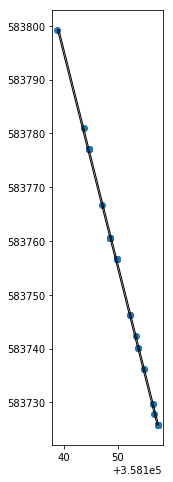

In [7]:
import scipy.optimize
import matplotlib.patches

def to_coords(angle, data):
    xcs = np.cos(angle) * data[:,0] - np.sin(angle) * data[:,1]
    ycs = np.sin(angle) * data[:,0] + np.cos(angle) * data[:,1]
    return xcs, ycs

def score(angle, data):
    xcs, ycs = to_coords(angle, data)
    ymin, ymax = np.min(ycs), np.max(ycs)
    return ymax - ymin

def rectangle(data):
    def f(a):
        return score(a, data)
    angle = scipy.optimize.brute(f, [[0, 2*np.pi]])[0]
    
    while True:
        xcs, ycs = to_coords(angle, data)
        xmin, xmax = np.min(xcs), np.max(xcs)
        ymin, ymax = np.min(ycs), np.max(ycs)
        xd, yd = xmax-xmin, ymax-ymin
        if xd >= yd:
            break
        angle += np.pi / 2
    #if xd > 1000:
    #    raise AssertionError()
    out = np.asarray([[xmin,ymin], [xmax,ymin], [xmax,ymax], [xmin,ymax]])
    return np.array(to_coords(-angle, out)).T

key = list(out)[0]
data = out[key]
rect = rectangle(data)

fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(*data.T)

p = matplotlib.patches.Polygon(rect, fc="none", ec="black", linewidth=1)
ax.add_patch(p)
ax.set_aspect(1)

In [8]:
import shapely.geometry

rects = {}
for key in out:
    rect = rectangle(out[key])
    rects[key] = shapely.geometry.Polygon(rect)

In [9]:
xmin, ymin, xmax, ymax = next(iter(rects.values() )).bounds
for r in rects.values():
    x1,y1,x2,y2 = r.bounds
    xmin = min(xmin, x1)
    xmax = max(xmax, x2)
    ymin = min(ymin, y1)
    ymax = max(ymax, y2)    

[(548675.7459587271, 599065.1055438551),
 (329326.25442109397, 370774.2599025388)]

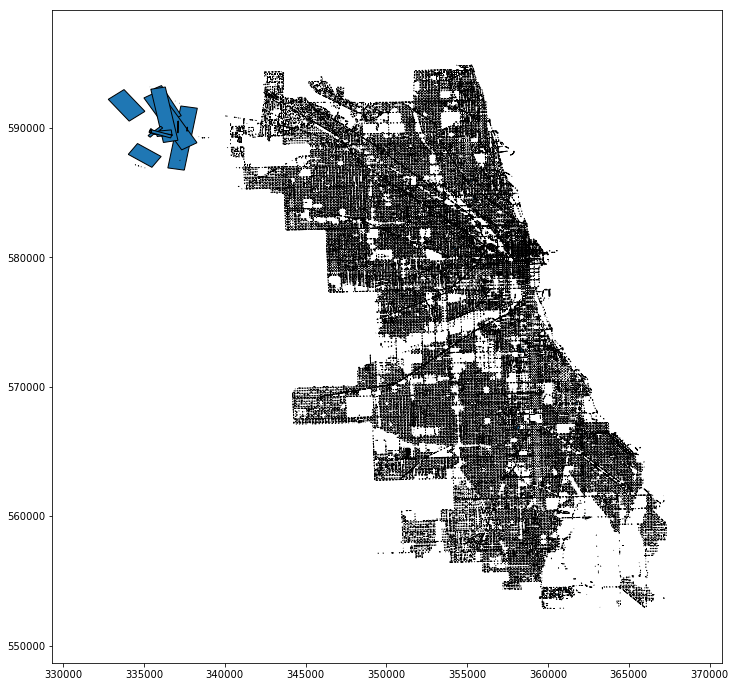

In [10]:
import descartes

fig, ax = plt.subplots(figsize=(12,12))

for r in rects.values():
    p = descartes.PolygonPatch(r)
    ax.add_patch(p)
    
xd, yd = xmax - xmin, ymax - ymin
xd *= 0.1
yd *= 0.1
ax.set(xlim=[xmin-xd,xmax+xd], ylim=[ymin-yd,ymax+yd])

In [11]:
keys = list(rects)
frame = gpd.GeoDataFrame({"block":keys})
frame.geometry = [rects[k] for k in keys]
frame.crs = {"init":"epsg:3528"}
frame.to_file("chicago_block_rects")

# Find overlaps

In [487]:
keys = list(rects)
for k1 in keys:
    for k2 in keys:
        if k1 == k2:
            continue
        p = rects[k1].intersection(rects[k2])
        if not p.is_empty:
            print(k1, k2)

037XX N WILTON AVE 037XX N WILTON AV
077XX S EUCLID AVE 077XX S EUCLID AV
068XX S WASHTENAW AVE 068XX S WASHTENAW AV
0000X N KENTON AVE 0000X N KENTON AV
051XX S DAMEN AVE 052XX S DAMEN AVE
051XX S DAMEN AVE 051XX S DAMEN AV
069XX S MERRILL AVE 069XX S MERRILL AV
012XX N MAPLEWOOD AVE 012XX N MAPLEWOOD AV
044XX N ST LOUIS AVE 044XX N ST LOUIS AV
024XX W HADDON AVE 024XX W HADDON AV
0000X W DIVISION ST 011XX N STATE ST
0000X W DIVISION ST 0000X W ELM ST
0000X W DIVISION ST 010XX N RUSH ST
0000X W DIVISION ST 012XX N DEARBORN ST
0000X W DIVISION ST 011XX N DEARBORN ST
0000X W DIVISION ST 011XX N RUSH ST
053XX S HOMAN AVE 053XX S HOMAN AV
039XX W ARMITAGE AVE 039XX W ARMITAGE AV
015XX N LARAMIE AVE 015XX N LARAMIE AV
004XX S CICERO AVE 004XX S CICERO AV
020XX W 70TH PL 020XX W 70 PL
015XX N LEAMINGTON AVE 015XX N LEAMINGTON AV
001XX N PINE AVE 001XX N PINE AV
035XX W MEDILL AVE 023XX N DRAKE AVE
035XX W MEDILL AVE 023XX N DRAKE AV
017XX W FULLERTON AVE 017XX W FULLERTON AV
029XX N MILWAUK

KeyboardInterrupt: 

## Only needed in construction: Visualing the errors...

In [463]:
i, key = None, '006XX W OHARE ST'

data = out[key]
def f(a):
    return score(a, data)
angle = scipy.optimize.brute(f, [[0, np.pi]])[0]
xcs, ycs = to_coords(angle, data)

def part(x):
    return np.max(np.abs(xcs-x))
x = scipy.optimize.brute(part, [[np.min(xcs), np.max(xcs)]])[0]
if part(x) > 200:
    before, after = xcs < x, xcs >= x

(None, '006XX W OHARE ST')

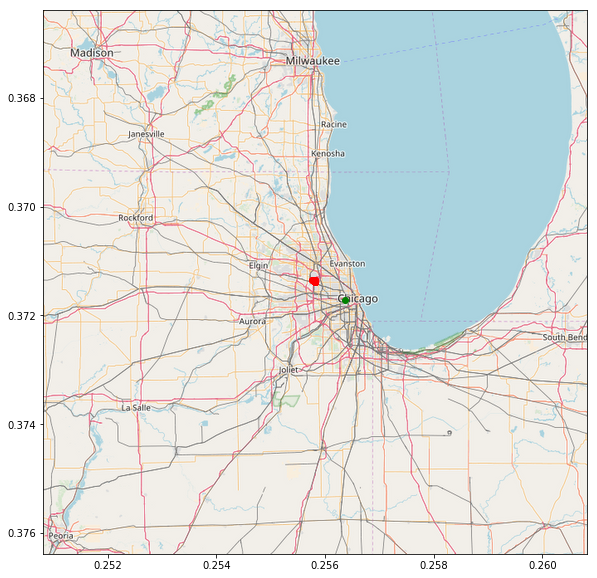

In [464]:
pts = out[key]
pts = proj(*pts.T, inverse=True)
ptstmb = []
for x,y in zip(*pts):
    ptstmb.append( tilemapbase.project(x, y) )
ptstmb = np.array(ptstmb).T
    
fig, ax = plt.subplots(figsize=(10,10))

xmin, xmax = np.min(ptstmb[0]), np.max(ptstmb[0])
ymin, ymax = np.min(ptstmb[1]), np.max(ptstmb[1])
x, y = np.mean(ptstmb[0]), np.mean(ptstmb[1])
ex = tilemapbase.Extent.from_centre(x, y, xsize=0.01)
plotter = tilemapbase.Plotter(ex, tilemapbase.tiles.OSM, width=600)
plotter.plot(ax)

ax.scatter(*ptstmb.T[before].T, color="red")
ax.scatter(*ptstmb.T[after].T, color="green")
#ax.scatter(*ptstmb)
i, key

In [426]:
for i in out_indices[key][before]:
    print(original_rows[i])

('025XX S BLUE ISLAND AV', 354242.2062642494, 575296.5703905098, '02/20/2002 10:30:00 AM', 'ASSAULT', 'SIMPLE', 'RESIDENCE')
('025XX S BLUE ISLAND AV', 354242.2062642494, 575296.5703905098, '04/14/2002 02:40:32 PM', 'ROBBERY', 'STRONGARM - NO WEAPON', 'STREET')


In [427]:
for i in out_indices[key][after]:
    print(original_rows[i])

('025XX S BLUE ISLAND AV', 353978.24947269604, 575159.1055949086, '01/16/2002 05:25:48 AM', 'THEFT', '$500 AND UNDER', 'SIDEWALK')
('025XX S BLUE ISLAND AV', 353932.2246741688, 575135.0263956791, '01/13/2002 01:21:00 PM', 'BATTERY', 'AGGRAVATED: OTHER DANG WEAPON', 'SIDEWALK')
('025XX S BLUE ISLAND AV', 353940.4542739055, 575139.2935955427, '01/19/2002 11:25:37 AM', 'ARSON', 'BY FIRE', 'VEHICLE NON-COMMERCIAL')
('025XX S BLUE ISLAND AV', 353836.51747723145, 575084.7343972885, '02/16/2002 08:15:00 AM', 'CRIMINAL DAMAGE', 'TO PROPERTY', 'SMALL RETAIL STORE')
('025XX S BLUE ISLAND AV', 353951.4270735543, 575145.0847953573, '03/03/2002 09:10:00 PM', 'WEAPONS VIOLATION', 'UNLAWFUL POSS OF HANDGUN', 'RESIDENCE')
('025XX S BLUE ISLAND AV', 353951.4270735543, 575145.0847953573, '03/24/2002 03:50:51 AM', 'BATTERY', 'SIMPLE', 'STREET')
